In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import itertools

from pyqubo import Binary, Array
from pprint import pprint
from qat.lang.AQASM import Program, QRoutine, RZ, RX, CNOT, H, X
from qat.core import Observable, Term
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problema da Cobertura Exata (Exact Cover Problem)

Considere um conjunto $U = \{1, \ldots, n\}$ e uma coleção de subconjuntos.
$V = \{V_1, V_2, \ldots, V_N\} \subseteq 2^U$
Uma cobertura de C com os conjuntos da coleção V é definida como o conjunto dos conjuntos $\{V_j, \ldots, V_k\} \subseteq V$ tal que
$$\bigcup_{i\in C} V_i = U$$
Para uma cobertura ser exata, os conjuntos que definem a cobertura devem ser disjuntos. Isso quer dizer que os elementos de $U$ pertencem a apenas um dos subconjuntos $V_i \in C$

In [2]:
U = [1,2,3,4,5,6]
V = [{1,2,3}, {4,5,6}, {1}, {2}, {3}, {4}, {5}, {6}]
#V = [{1,2,3}, {4,5,6}, {1,4}, {2,5}, {3,6}]
#U = [1,2,3,4,5,6,7]
#V = [{1,7}, {1,4,7}, {1,4}, {4,5,7}, {3,5,6}, {2,3,6}, {2,7}]

## Classe de Complexidade

Quando formulado como um problema de decisão ("Existe um conjunto C que é uma cobertura exata de U?") esse problema é NP-Completo.

Quando formulado como um problema de otimização ("Qual é o menor conjunto C que é uma cobertura exata de U?") esse problema é NP-Hard.

## Aplicações

Por ser um problema NP-Completo, qualquer problema da classe NP pode ser reduzido para o Problema de Cobertura Exata e com isso ser resolvido com técnicas específicas para ele. Contudo, alguns problemas possuem uma redução particularmente diretas. Por exemplo, o problema dos Pentaminós e o Sudoku. O problema das $n$ rainhas também é uma versão mais generalizada do problema da cobertura exata.

<p align="center">
<img src="pentominoe.png" width="300" />
<img src="sudoku.png" width="300" />
<img src="nqueen.png" width="300" />
</p>

Em problemas mais aplicados, a Cobertura Exata pode ser usada nos seguintes contextos:

**Planejamento Urbano**: Onde devem ser construídos prédios de serviços públicos (bombeiros, hospitais...) de forma a se cobrir uma maior área da cidade com menor gasto de recursos?

**Planejamento de Turnos**: Como deve ser dividida a carga horária entre os funcionários (ou recursos como trens, aviões...) para se cobrir todos os turnos?

**Roteamento de Veículos**: Qual é o conjunto ótimo de rotas que uma frota de veículos deve seguir para fazer as entregas necessárias a um grupo de clientes?

## Hamiltoniano

O Hamiltoniano é um operador que codifica a função a ser otimizada. No caso da Cobertura Exata, o Hamiltoniano toma a forma $$ H = \sum^n_{\alpha=1} (1 - \sum_{i:\alpha\in V_i} x_i)^2.$$

No hamiltoniano acima $\alpha$ representa os elementos de $U$ e $V_i$ representa os subconjuntos contidos em $V$. A variável $x_i$ assume o valor $1$ se o subconjunto $V_i$ faz parte da cobertura $C$. $H = 0$ ocorre quando cada elemento é incluído apenas 1 vez, o que significa que os conjuntos são disjuntos. A existência de um estado base onde a energia $H = 0$ corresponde a existência de uma solução para o Problema da Cobertura Exata. Se o estado base é degenerado, existem múltiplas soluções. Um total de N qubits são necessários, onde $N = |V|$. É possível estender esse hamiltoniano para que ele encontre a menor cobertura exata. Para isso é necessário acrescentar uma segunda escala de energia $$ H = A \sum^n_{\alpha=1} (1 - \sum_{i:\alpha\in V_i} x_i)^2 + B\sum_i x_i.$$

O estado base do novo Hamiltoniano terá energia $H = mB$, onde $m$ é o menor número de subconjuntos que formam uma cobertura. Para garantir a formulação correta do problema, os valores $A$ e $B$ devem seguir a proporção $A > nB$ onde $n = |U|$.

In [3]:
variables = Array.create('x', shape=len(V), vartype='BINARY')
print(variables)

Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]'), Binary('x[5]'), Binary('x[6]'), Binary('x[7]')])


In [4]:
A = 12
HA = 0
for alpha in U:
    temp = sum(variables[i] for i, Vi in enumerate(V) if alpha in Vi)
    HA += (1-temp)**2
HA *= A

B = 1
HB = B * sum(x for x in variables)

Hamil = HA + HB
print(Hamil)

(((((1.000000 + (-1.000000 * (Binary('x[7]') + 0.000000 + Binary('x[1]')))) * (1.000000 + (-1.000000 * (Binary('x[7]') + 0.000000 + Binary('x[1]'))))) + ((1.000000 + (-1.000000 * (Binary('x[6]') + 0.000000 + Binary('x[1]')))) * (1.000000 + (-1.000000 * (Binary('x[6]') + 0.000000 + Binary('x[1]'))))) + ((1.000000 + (-1.000000 * (Binary('x[5]') + 0.000000 + Binary('x[1]')))) * (1.000000 + (-1.000000 * (Binary('x[5]') + 0.000000 + Binary('x[1]'))))) + ((1.000000 + (-1.000000 * (Binary('x[4]') + 0.000000 + Binary('x[0]')))) * (1.000000 + (-1.000000 * (Binary('x[4]') + 0.000000 + Binary('x[0]'))))) + ((1.000000 + (-1.000000 * (Binary('x[3]') + 0.000000 + Binary('x[0]')))) * (1.000000 + (-1.000000 * (Binary('x[3]') + 0.000000 + Binary('x[0]'))))) + 0.000000 + ((1.000000 + (-1.000000 * (Binary('x[2]') + 0.000000 + Binary('x[0]')))) * (1.000000 + (-1.000000 * (Binary('x[2]') + 0.000000 + Binary('x[0]')))))) * 12.000000) + (1.000000 * (Binary('x[7]') + Binary('x[6]') + Binary('x[5]') + Binary('

## Modelar como QUBO

Um Quadratic Unconstrained Binary Optimization (QUBO) é um problema de otimização combinatória com aplicabilidade em muitas áreas, como finanças e aprendizado de máquina. O QUBO é um problema NP-hard, e muitos problemas conhecidos da computação, como Max-Cut, coloração de grafos, etc, possuem formulações na forma de QUBO. Devido a sua proximidade com o modelo de Ising, o QUBO se tornou uma classe central de problemas para a computação adiabática, onde ele é resolvido através do processo de Quantum Annealing.

Em resumo, um QUBO é
 - Um problema matemático;
 - Declarado em variáveis binárias;
 - Com variáveis lineares ou quadráticas;
 - Que pode incluir restrições.

$$H_{QUBO} = -\sum_i^N h_ix_i - \sum_{i<j} J_{ij} x_ix_j $$

In [5]:
model = Hamil.compile()
qubo = model.to_qubo()
print(qubo)

({('x[4]', 'x[4]'): -11.0, ('x[1]', 'x[1]'): -35.0, ('x[1]', 'x[5]'): 24.0, ('x[0]', 'x[2]'): 24.0, ('x[4]', 'x[0]'): 24.0, ('x[7]', 'x[1]'): 24.0, ('x[2]', 'x[2]'): -11.0, ('x[6]', 'x[6]'): -11.0, ('x[0]', 'x[3]'): 24.0, ('x[1]', 'x[6]'): 24.0, ('x[3]', 'x[3]'): -11.0, ('x[7]', 'x[7]'): -11.0, ('x[5]', 'x[5]'): -11.0, ('x[0]', 'x[0]'): -35.0}, 72.0)


Para resolvermos o nosso problema usando o myQLM criaremos um observável usando o Hamiltoniano do QUBO criado acima.

In [6]:
single_values = {}
multiple_values = {}
for k,v in qubo[0].items():
    if k[0] == k[1]:
        single_values[int(k[0][2])] = v
    else:
        multiple_values[(int(k[0][2]), int(k[1][2]))] = v

num_qubits = len(variables)
hamiltonian_exact_cover = Observable(num_qubits,
                           pauli_terms=
                           [Term(single_values[x], "Z", [x]) for x in single_values]+
                           [Term(multiple_values[x], "ZZ", [x[0],x[1]]) for x in multiple_values],
                           constant_coeff=qubo[1]
                           )

print(hamiltonian_exact_cover)

72.0 * I^8 +
-11.0 * (Z|[4]) +
-35.0 * (Z|[1]) +
-11.0 * (Z|[2]) +
-11.0 * (Z|[6]) +
-11.0 * (Z|[3]) +
-11.0 * (Z|[7]) +
-11.0 * (Z|[5]) +
-35.0 * (Z|[0]) +
24.0 * (ZZ|[1, 5]) +
24.0 * (ZZ|[0, 2]) +
24.0 * (ZZ|[4, 0]) +
24.0 * (ZZ|[7, 1]) +
24.0 * (ZZ|[0, 3]) +
24.0 * (ZZ|[1, 6])


In [7]:
hamiltonian_exact_cover.terms

[Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-11.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='Z', qbits=[4], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-35.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='Z', qbits=[1], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-11.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='Z', qbits=[2], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-11.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='Z', qbits=[6], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-11.0, string_p=None, matrix_p=None, serialized_p=None, complex_p=None), op='Z', qbits=[3], _do_validity_check=True), Term(_coeff=TNumber(is_abstract=False, type=1, int_p=None, double_p=-

## Circuito QAOA

<p align="center">
<img src="qaoa_cirq.png" width="800" />
</p>

### Separador de Fase

Construa o Operador de Fase do QAOA a partir do Hamiltoniano QUBO criado anteriormente.

DICA:
<p align="center">
<img src="rzz.png" width="600" />
</p>

In [8]:
# DICA: os termos do observável podem ser acessados pelo atributo observable.terms
#       Cada termo armazena o tipo de operação em term.ops e os qubits operados em term.qbits
def phase_separator_exact_cover(qreg, gamma, observable):
    single_values = [t.qbits for t in observable.terms if len(t.qbits) == 1]
    multiple_values = [t.qbits for t in observable.terms if len(t.qbits) > 1]
    for i in single_values:
        RZ(gamma)(qreg[i[0]])
    for j in multiple_values:
        CNOT(qreg[j[0]], qreg[j[1]])
        RZ(2*gamma)(qreg[j[1]])
        CNOT(qreg[j[0]], qreg[j[1]])

### Misturador (Mixer)

O Operador de Mistura realiza uma busca pelo espaço da solução, e pode ser implementado em sua forma mais simples seguindo o modelo:

$$U(\beta) = \bigotimes_{i=0}^{n} R_X(2\beta)$$

In [9]:
def mixer_exact_cover(qreg, beta):
    for q in qreg:
        RX(beta)(q)

### Estado Inicial

Como estado inicial, prepare a superposição uniforme de todos os estados:

$$|s\rangle =  \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |i\rangle$$

In [10]:
def initial_state(qreg, num_qubits):
    for q in range(num_qubits):
        H(qreg[q])

In [11]:
# --------------------------
# Running QAOA for Max Independent Set on simulator
# --------------------------

# -------------------
# Initializing qubits
# -------------------
p = 1
qprog = Program()
qbits = qprog.qalloc(num_qubits)

gamma  = [qprog.new_var(float, '\\gamma_%s'%i) for i in range(1,p+1)]
beta   = [qprog.new_var(float, '\\beta_%s'%i) for i in range(1,p+1)]

# --------------------------
# Initial state preparation
# --------------------------
initial_state(qbits, num_qubits)
# ----------------------------------
# Alternate application of operators
# ----------------------------------
for step in range(p):
    phase_separator_exact_cover(qbits, gamma[step], hamiltonian_exact_cover)
    mixer_exact_cover(qbits, beta[step])

### Visualização do Circuito

In [12]:
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
print("Variables:", circuit.get_variables())
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  42
Variables: ['\\beta_1', '\\gamma_1']


## Rodar o Circuito usando QLM

In [13]:
# Create a job
job = circuit.to_job(observable=hamiltonian_exact_cover)

result_list = []
# Escolha um número de iterações adequado
num_iterations = 10
for _ in range(num_iterations):
    # Inicialize p parâmetros gamma e p parâmetros beta iniciais entre os valores (0, 2*pi)
    initial_parameters = [random.uniform(0, 2*np.pi) for _ in range(2*p)]
    cobyla = ScipyMinimizePlugin(tol=1e-6,
                                method="COBYLA",
                                options={"maxiter": 300},
                                x0=initial_parameters)
    # Create a Quantum Processor Unit
    qpu = get_default_qpu()

    stack = cobyla | qpu

    # Submit the job to the QPU
    result_list.append(stack.submit(job))

## Análise dos Resultados

In [14]:
for i, r in enumerate(result_list):
    print("Run", i, ", Final energy:", r.value)
    #Binding the variables:random.uniform(0, 2*np.pi)
    sol_job = job(**eval(r.meta_data["parameter_map"]))

    #Rerunning in 'SAMPLE' mode to get the most probable states:
    sampling_job = sol_job.circuit.to_job()

    sol_res = qpu.submit(sampling_job)
    print("Most probable states are:")
    for sample in sol_res:
        if sample.probability > 0.05:
            print(sample.state, "{:.2f}%".format(100 * sample.probability))

Run 0 , Final energy: 19.514574014319976
Most probable states are:
|11000000> 6.95%
Run 1 , Final energy: 22.64017208100052
Most probable states are:
|00111111> 8.52%
Run 2 , Final energy: -12.7563335277205
Most probable states are:
|11000000> 8.85%
Run 3 , Final energy: 19.51457401447923
Most probable states are:
|11000000> 6.95%
Run 4 , Final energy: 19.514574014314164
Most probable states are:
|11000000> 6.95%
Run 5 , Final energy: 39.88888888969328
Most probable states are:
|00000000> 8.62%
Run 6 , Final energy: 19.514574014584838
Most probable states are:
|11000000> 6.95%
Run 7 , Final energy: 19.51457401448235
Most probable states are:
|11000000> 6.95%
Run 8 , Final energy: -12.756333527002667
Most probable states are:
|11000000> 8.85%
Run 9 , Final energy: 19.514574014362857
Most probable states are:
|11000000> 6.95%


In [15]:
# Escolhendo o resultado com o menor valor esperado
result = min(result_list, key=lambda s: s.value)
print("Final energy:", result.value)
for key, value in result.meta_data.items():
    print(key, ":", value)

Final energy: -12.7563335277205
optimizer_data :      fun: -12.7563335277205
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 64
  status: 1
 success: True
       x: array([3.95680672, 3.52767191])
parameters : [3.956806716254012, 3.5276719103699095]
optimization_trace : [-8.573157680801089, 70.60256571634511, 195.51113175573775, 119.42094209950164, 80.67846444149352, -11.310352833307803, -4.416511427400948, 23.5626636912844, -4.242330894395138, -12.439521456264728, -12.500733188301965, -12.542850179193124, -11.640420884552753, -12.45376603035622, -12.639756980963199, -12.614303766711785, -12.71696124986984, -12.733479923394967, -12.692081283848879, -12.746535544367617, -12.704831283765444, -12.755261820554495, -12.754377197642143, -12.748983134674262, -12.753948592588046, -12.754568089788876, -12.75575669356499, -12.756195405716454, -12.756191028504148, -12.75621553279504, -12.756140803671073, -12.756177841694154, -12.756275267096484, -12.756310763806795, -12.

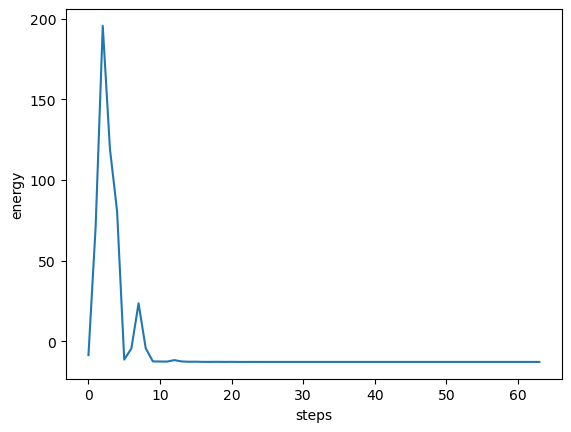

In [16]:
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

In [17]:
def exact_cover_obj(result, U, V):
    solution = [Vi for i, Vi in enumerate(V) if result[i] == '1']
    for i in itertools.combinations(solution, 2):
        if len(i[0].intersection(i[1])) != 0:
            return np.inf
    cover = set().union(*solution)
    difference = set(U) - cover
    if len(difference) == 0:
        return len(solution)
    else:
        return np.inf

In [18]:
# Emulating a reasonable setup:
# Drawing 2048 cuts
sol_job = job(**eval(result.meta_data["parameter_map"]))
sampling_job = sol_job.circuit.to_job(nbshots=2048)
sol_res = qpu.submit(sampling_job)

max_state = max([(s.state.value[0], s.probability) for s in sol_res], key=lambda s: s[1])
print("State with highest probability:"
      , max_state[0]
      , "%.2f%%" % (100 * max_state[1])
      , [Vi for i, Vi in enumerate(V) if max_state[0][i] == '1'] )

tuple_list = [(s.state.value[0], s.probability, exact_cover_obj(s.state.value[0],U,V)) for s in sol_res]
exact_cover = min(tuple_list, key=lambda s: s[2])
print(
    "Best answer found:"
    , exact_cover[0]
    , "%.2f%%" % (100 * exact_cover[1])
    , [Vi for i, Vi in enumerate(V) if exact_cover[0][i] == '1'] )

State with highest probability: 11000000 8.89% [{1, 2, 3}, {4, 5, 6}]
Best answer found: 11000000 8.89% [{1, 2, 3}, {4, 5, 6}]
